In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torch
import torch.nn.functional as F

In [3]:
words = open('names.txt').read().splitlines()
len(words), words[:8]

(32033,
 ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia'])

In [4]:
# let's only have one special token, and let's have it at index 0, offset others by 1
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
num_classes = len(stoi)
vocab_size = len(itos)
print(vocab_size, itos)

27 {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
def build_dataset(words, block_size):
    X, Y, = [], [] # X, input | Y, labels

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append moving window

    X = torch.tensor(X)
    Y = torch.tensor(Y)    
    return X, Y

In [6]:
# Splits
import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

block_size = 3 # context length : How many characters do we take to predict the next one : 3 chars to predict the 4th

Xtr, Ytr = build_dataset(words[:n1], block_size)
Xva, Yva = build_dataset(words[n1:n2], block_size)
Xte, Yte = build_dataset(words[n2:], block_size)

Xtr.shape, Ytr.shape, Xva.shape, Yva.shape, Xte.shape, Yte.shape

(torch.Size([182625, 3]),
 torch.Size([182625]),
 torch.Size([22655, 3]),
 torch.Size([22655]),
 torch.Size([22866, 3]),
 torch.Size([22866]))

In [7]:
# Pytorch like layers

In [8]:
class Linear:
    
    def __init__(self, gen, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=gen) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

In [9]:
class BatchNorm1D:
    
    def init(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # learnable parameters
        self.gamma = torch.ones(dim)  # gain
        self.beta  = torch.zeros(dim) # bias
        # buffers (calculated with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var  = torch.ones(dim)
        
    def __call__(self, x):
        # forward pass
        if self.training:
            xmean = x.mean(dim=0, keepdim=True)
            xvar  = x.var(dim=0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar  = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        # updating running buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var  = (1 - self.momentum) * self.running_var + self.momentum * xvar
                
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

In [10]:
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

In [11]:
g = torch.Generator().manual_seed(2147483647)

In [12]:
n_embed = 10   # dimensionality of characters in the embedding vector
n_hidden = 100 # number of neurons in the hidden layer

C = torch.randn((vocab_size, n_embed), generator=g) # embedding matrix

# stack up the layers
layers = [
    Linear(g, n_embed * block_size, n_hidden), Tanh(),
    Linear(g,             n_hidden, n_hidden), Tanh(),
    Linear(g,             n_hidden, n_hidden), Tanh(),
    Linear(g,             n_hidden, n_hidden), Tanh(),
    Linear(g,             n_hidden, n_hidden), Tanh(),
    Linear(g,             n_hidden, vocab_size),
]

In [13]:
# initialisation
with torch.no_grad():
    # make last layer less confident
    layers[-1].weight *= 0.1
    # all other layers, apply gain (in prep for tanh)
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

In [14]:
# prepare parameters
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

46497


In [15]:
max_steps = 200000
batch_size = 32

In [16]:
lossi = []
losslog10i = []
stepsi = []

In [17]:
tot_steps = len(stepsi)

for i in range(max_steps):
    # construct minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y
    
    # forward pass
    emb = C[Xb]                    # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)  # loss function
    
    # backward pass
    for layer in layers:
        layer.out.retain_grad()    # AFTERWARDS : take out the retain grad, we want to visualise this that's why
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01    # switch learning rate
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    stepsi.append(tot_steps+i)
    lossi.append(loss.item())
    losslog10i.append(loss.log10().item())
    
    # Print loss 
    if (i)%(max_steps/10) == 0:
        print(f"Loss {i}/{max_steps}: {loss.item()}")
        
    break # AFTERWARDS : take out so can fully train

Loss 0/200000: 3.296154737472534


In [18]:
# Lets visualise what's going on with the activations and gradients at all the tanh layers out

layer 1 (      Tanh): mean: +0.000010, std: 4.205588e-04
layer 3 (      Tanh): mean: -0.000003, std: 3.991179e-04
layer 5 (      Tanh): mean: +0.000003, std: 3.743020e-04
layer 7 (      Tanh): mean: +0.000015, std: 3.290473e-04
layer 9 (      Tanh): mean: -0.000014, std: 3.054035e-04


Text(0.5, 1.0, 'Gradient distribution')

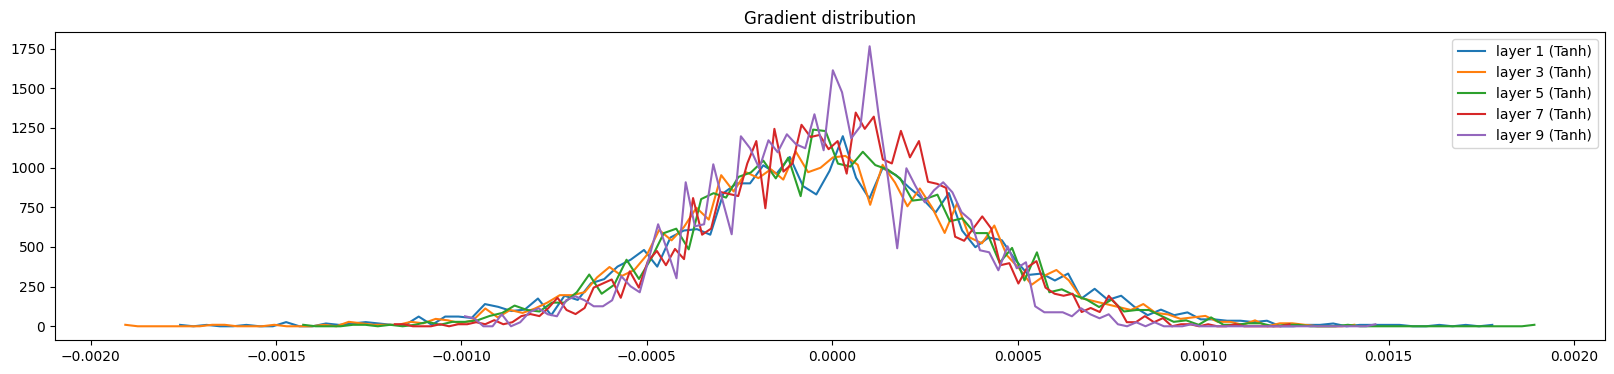

In [19]:
# visualize forward pass
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean: %+f, std: %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('Gradient distribution')

layer 1 (      Tanh): mean: +0.000010, std: 4.205588e-04
layer 3 (      Tanh): mean: -0.000003, std: 3.991179e-04
layer 5 (      Tanh): mean: +0.000003, std: 3.743020e-04
layer 7 (      Tanh): mean: +0.000015, std: 3.290473e-04
layer 9 (      Tanh): mean: -0.000014, std: 3.054035e-04


Text(0.5, 1.0, 'Gradient distribution')

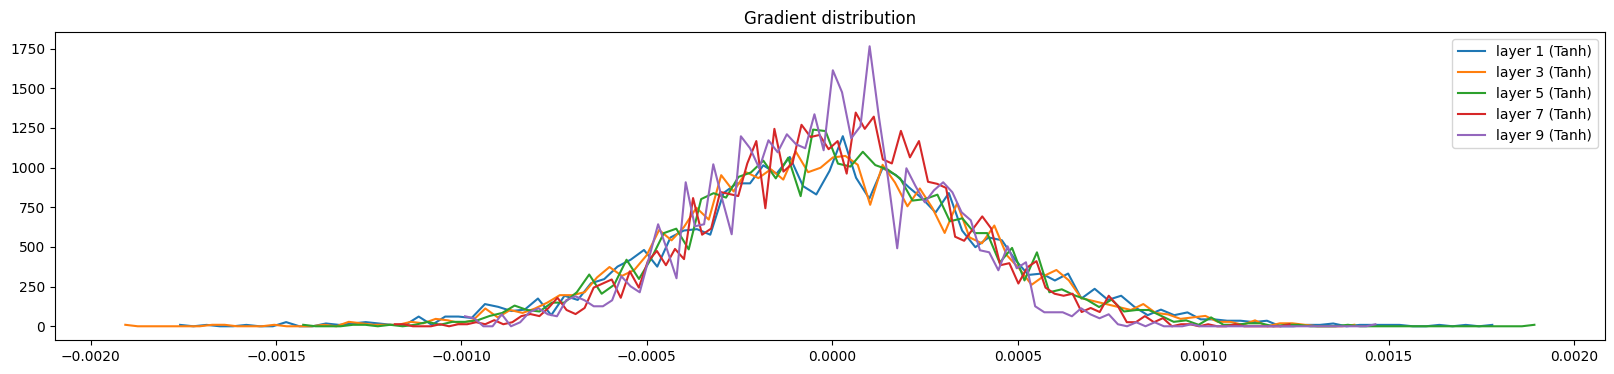

In [20]:
# visualize forward pass
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean: %+f, std: %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('Gradient distribution')

weight   (27, 10) | mean +-0.000031 | std 1.365078e-03 | grad:data ratio 1.364090e-03
weight  (30, 100) | mean +-0.000049 | std 1.207430e-03 | grad:data ratio 3.871660e-03
weight (100, 100) | mean +0.000016 | std 1.096730e-03 | grad:data ratio 6.601988e-03
weight (100, 100) | mean +-0.000010 | std 9.893572e-04 | grad:data ratio 5.893091e-03
weight (100, 100) | mean +-0.000011 | std 8.623432e-04 | grad:data ratio 5.158124e-03
weight (100, 100) | mean +-0.000004 | std 7.388576e-04 | grad:data ratio 4.415211e-03
weight  (100, 27) | mean +-0.000000 | std 2.364824e-02 | grad:data ratio 2.328203e+00


Text(0.5, 1.0, 'Gradient distribution')

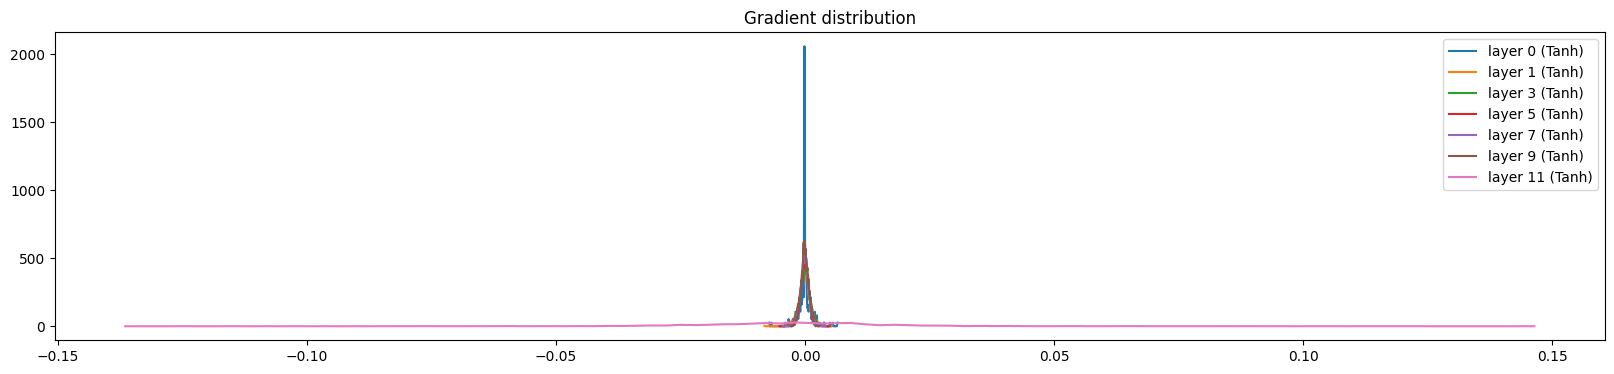

In [21]:
# visualise histograms
plt.figure(figsize=(20,4))
legends = []
for i,p in enumerate(parameters):
    if isinstance(layer, Tanh):
        if p.ndim == 2:
            t = p.grad
            print('weight %10s | mean +%f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std()/p.std()))
            hy, hx = torch.histogram(t, density=True)
            plt.plot(hx[:-1].detach(), hy.detach())
            legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('Gradient distribution')

In [22]:
# Some trouble with the histogram
# Mean, Std
# Gradient to Data ratio : important because we take a step update : if this number is high then you might have problem
# the last layer has a different grad to data ratio 

# this means that when doing SGD, you'd be training the last layer much more faster than the other layers (at init)

In [23]:
# This might get better if we train longer, let's try tthat

In [24]:
n_embed = 10   # dimensionality of characters in the embedding vector
n_hidden = 100 # number of neurons in the hidden layer

C = torch.randn((vocab_size, n_embed), generator=g) # embedding matrix

# stack up the layers
layers = [
    Linear(g, n_embed * block_size, n_hidden), Tanh(),
    Linear(g,             n_hidden, n_hidden), Tanh(),
    Linear(g,             n_hidden, n_hidden), Tanh(),
    Linear(g,             n_hidden, n_hidden), Tanh(),
    Linear(g,             n_hidden, n_hidden), Tanh(),
    Linear(g,             n_hidden, vocab_size),
]

In [25]:
# initialisation
with torch.no_grad():
    # make last layer less confident
    layers[-1].weight *= 0.1
    # all other layers, apply gain (in prep for tanh)
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

In [26]:
# prepare parameters
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

46497


In [27]:
max_steps = 200000
batch_size = 32

In [28]:
lossi = []
losslog10i = []
stepsi = []

In [29]:
tot_steps = len(stepsi)

for i in range(max_steps):
    # construct minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y
    
    # forward pass
    emb = C[Xb]                    # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)  # loss function
    
    # backward pass
    for layer in layers:
        layer.out.retain_grad()    # AFTERWARDS : take out the retain grad, we want to visualise this that's why
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01    # switch learning rate
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    stepsi.append(tot_steps+i)
    lossi.append(loss.item())
    losslog10i.append(loss.log10().item())
    
    # Print loss 
    if (i)%(max_steps/10) == 0:
        print(f"Loss {i}/{max_steps}: {loss.item()}")
    
    if i > 1000:
        break # AFTERWARDS : take out so can fully train

Loss 0/200000: 3.2992091178894043


In [30]:
# Lets visualise what's going on with the activations and gradients at all the tanh layers out

layer 1 (      Tanh): mean: +0.000027, std: 3.483514e-03
layer 3 (      Tanh): mean: +0.000035, std: 3.074236e-03
layer 5 (      Tanh): mean: -0.000039, std: 2.899778e-03
layer 7 (      Tanh): mean: -0.000032, std: 2.740667e-03
layer 9 (      Tanh): mean: -0.000017, std: 2.272380e-03


Text(0.5, 1.0, 'Gradient distribution')

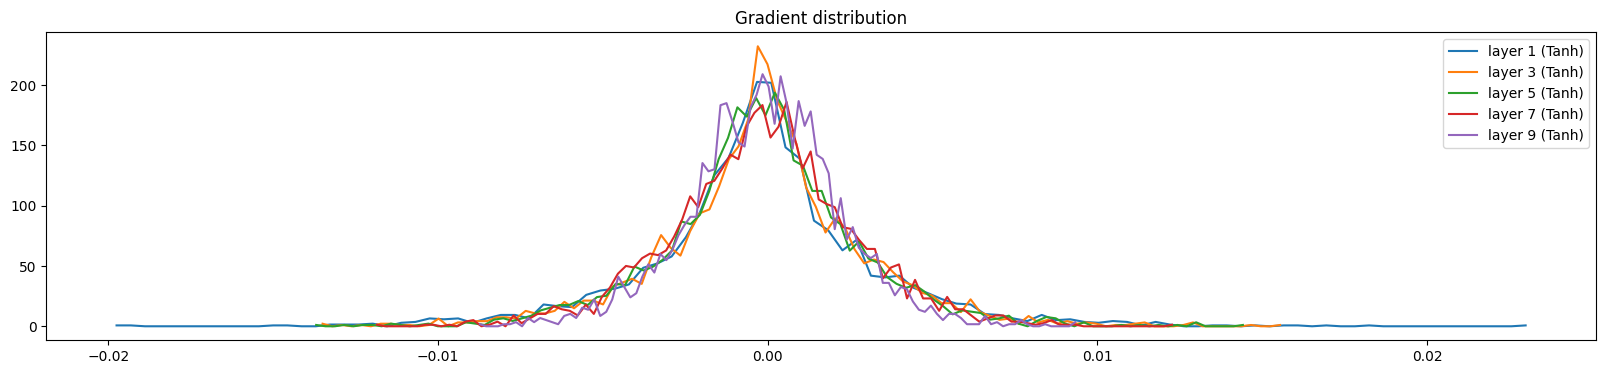

In [31]:
# visualize forward pass
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean: %+f, std: %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('Gradient distribution')

weight   (27, 10) | mean +-0.000446 | std 1.255390e-02 | grad:data ratio 1.201269e-02
weight  (30, 100) | mean +-0.000308 | std 1.037875e-02 | grad:data ratio 3.358731e-02
weight (100, 100) | mean +-0.000032 | std 7.638284e-03 | grad:data ratio 4.570204e-02
weight (100, 100) | mean +0.000038 | std 6.575938e-03 | grad:data ratio 3.931506e-02
weight (100, 100) | mean +0.000049 | std 6.061840e-03 | grad:data ratio 3.610900e-02
weight (100, 100) | mean +-0.000030 | std 5.352490e-03 | grad:data ratio 3.186667e-02
weight  (100, 27) | mean +0.000000 | std 2.092308e-02 | grad:data ratio 3.056053e-01


Text(0.5, 1.0, 'Histogram')

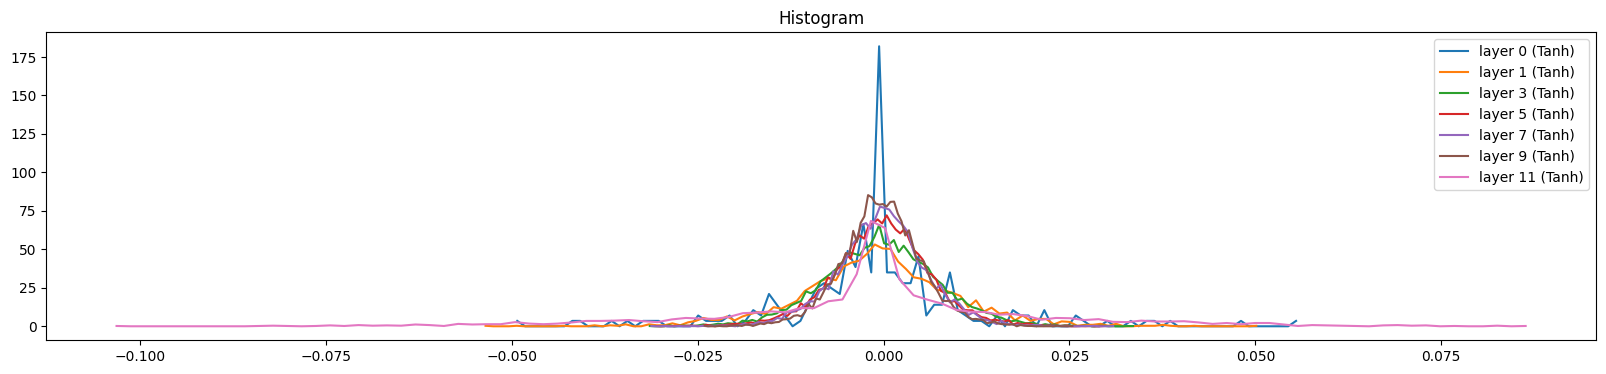

In [32]:
# visualise histograms
plt.figure(figsize=(20,4))
legends = []
for i,p in enumerate(parameters):
    if isinstance(layer, Tanh):
        if p.ndim == 2:
            t = p.grad
            print('weight %10s | mean +%f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std()/p.std()))
            hy, hx = torch.histogram(t, density=True)
            plt.plot(hx[:-1].detach(), hy.detach())
            legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('Histogram')

In [33]:
# After 100 iterations we can see that the last layer is indeed getting better as well

In [34]:
# But what matters in the end is not the gradient to dat ratio, but the update to data ratio
# that's teh amount by which we will update the weight
# so we will track that

In [35]:
n_embed = 10   # dimensionality of characters in the embedding vector
n_hidden = 100 # number of neurons in the hidden layer

C = torch.randn((vocab_size, n_embed), generator=g) # embedding matrix

# stack up the layers
layers = [
    Linear(g, n_embed * block_size, n_hidden), Tanh(),
    Linear(g,             n_hidden, n_hidden), Tanh(),
    Linear(g,             n_hidden, n_hidden), Tanh(),
    Linear(g,             n_hidden, n_hidden), Tanh(),
    Linear(g,             n_hidden, n_hidden), Tanh(),
    Linear(g,             n_hidden, vocab_size),
]

In [36]:
# initialisation
with torch.no_grad():
    # make last layer less confident
    layers[-1].weight *= 0.1
    # all other layers, apply gain (in prep for tanh)
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

In [37]:
# prepare parameters
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

46497


In [38]:
max_steps = 200000
batch_size = 32

In [39]:
lossi = []
losslog10i = []
stepsi = []

In [40]:
tot_steps = len(stepsi)
ud = []

for i in range(max_steps):
    # construct minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y
    
    # forward pass
    emb = C[Xb]                    # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)  # loss function
    
    # backward pass
    for layer in layers:
        layer.out.retain_grad()    # AFTERWARDS : take out the retain grad, we want to visualise this that's why
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01    # switch learning rate
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    stepsi.append(tot_steps+i)
    lossi.append(loss.item())
    losslog10i.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log().item() for p in parameters])
    
    # Print loss 
    if (i)%(max_steps/10) == 0:
        print(f"Loss {i}/{max_steps}: {loss.item()}")
    
    if i > 1000:
        break # AFTERWARDS : take out so can fully train

Loss 0/200000: 3.2974398136138916


layer 1 (      Tanh): mean: -0.02, std: +0.75, saturated: +17.66%
layer 3 (      Tanh): mean: +0.01, std: +0.72, saturated: +14.03%
layer 5 (      Tanh): mean: +0.01, std: +0.72, saturated: +12.69%
layer 7 (      Tanh): mean: -0.02, std: +0.72, saturated: +10.53%
layer 9 (      Tanh): mean: +0.01, std: +0.71, saturated: +11.41%


Text(0.5, 1.0, 'Activation distribution')

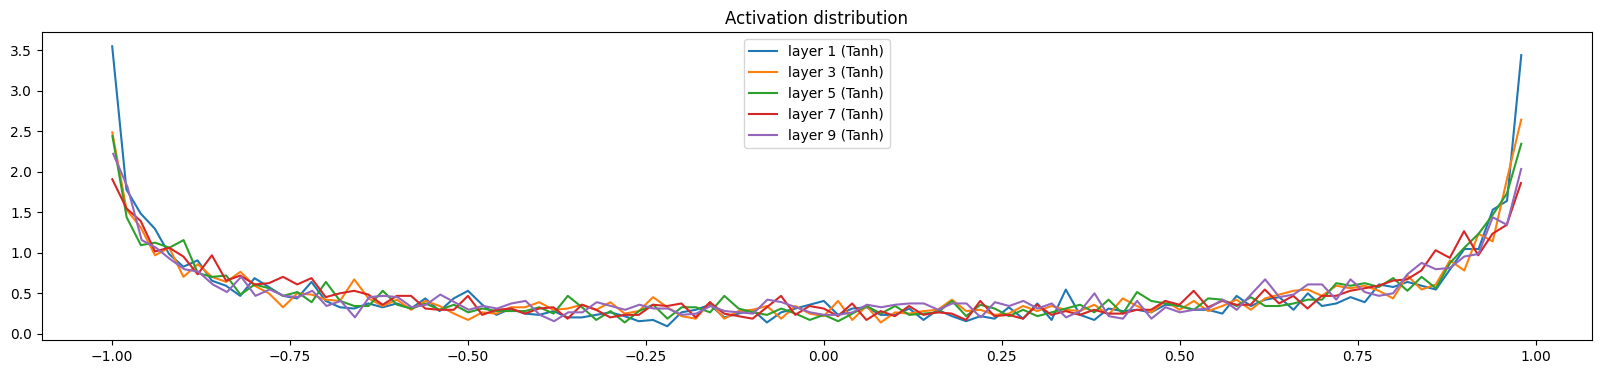

In [41]:
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean: %+.2f, std: %+.2f, saturated: %+.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('Activation distribution')

layer 1 (      Tanh): mean: -0.000002, std: 3.147575e-03
layer 3 (      Tanh): mean: -0.000017, std: 2.932212e-03
layer 5 (      Tanh): mean: +0.000050, std: 2.780322e-03
layer 7 (      Tanh): mean: +0.000010, std: 2.738921e-03
layer 9 (      Tanh): mean: -0.000004, std: 2.217845e-03


Text(0.5, 1.0, 'Gradient distribution')

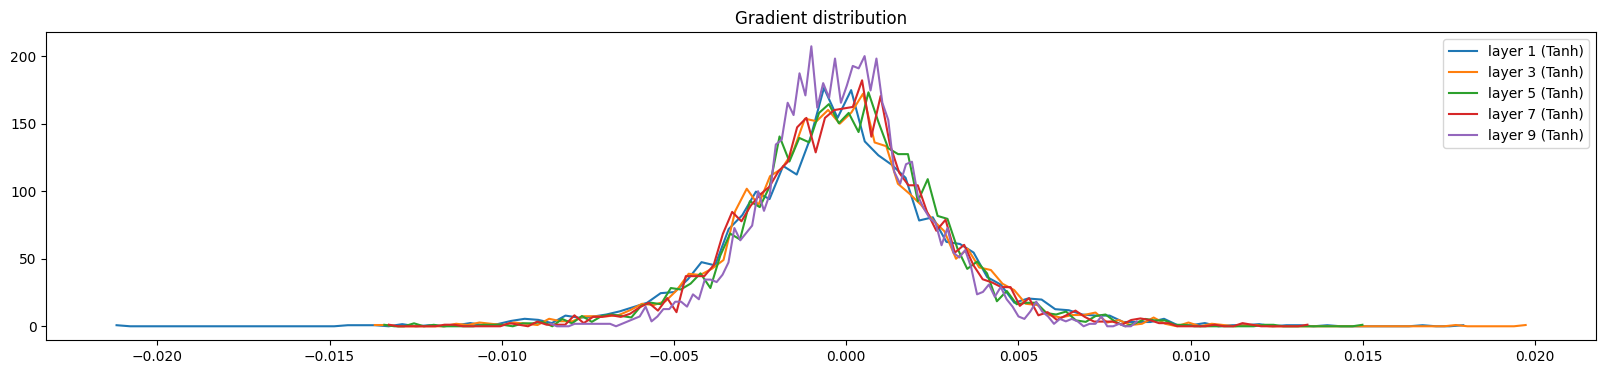

In [42]:
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean: %+f, std: %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('Gradient distribution')

weight   (27, 10) | mean +0.000973 | std 1.057591e-02 | grad:data ratio 1.059860e-02
weight  (30, 100) | mean +0.000056 | std 9.340049e-03 | grad:data ratio 3.067671e-02
weight (100, 100) | mean +-0.000037 | std 7.459766e-03 | grad:data ratio 4.409125e-02
weight (100, 100) | mean +-0.000137 | std 6.657493e-03 | grad:data ratio 3.928349e-02
weight (100, 100) | mean +0.000108 | std 6.165676e-03 | grad:data ratio 3.707483e-02
weight (100, 100) | mean +0.000012 | std 4.908364e-03 | grad:data ratio 2.920835e-02
weight  (100, 27) | mean +0.000000 | std 1.952215e-02 | grad:data ratio 2.845705e-01


Text(0.5, 1.0, 'Histogram')

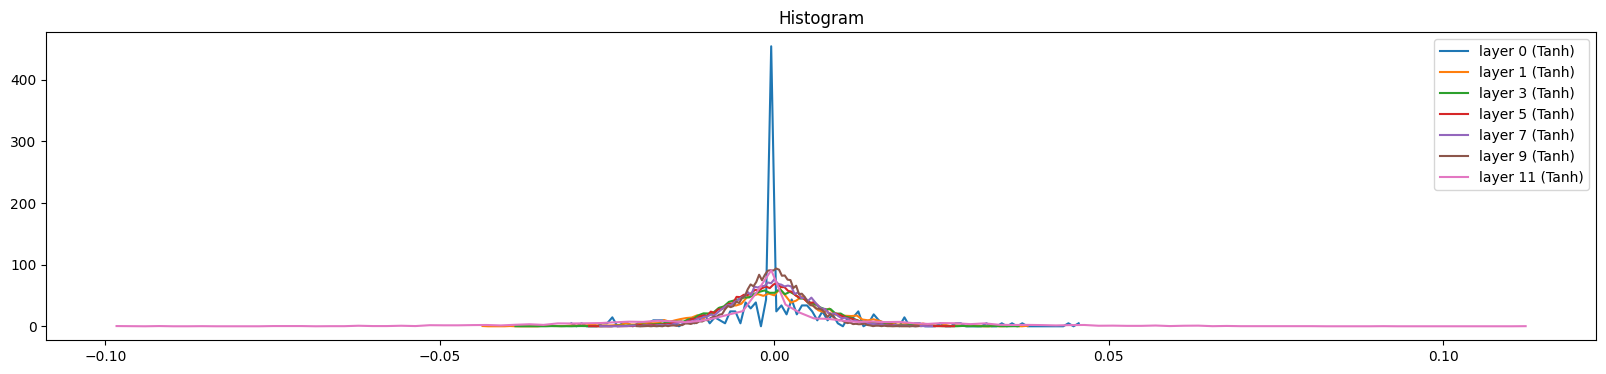

In [43]:
# visualise histograms
plt.figure(figsize=(20,4))
legends = []
for i,p in enumerate(parameters):
    if isinstance(layer, Tanh):
        if p.ndim == 2:
            t = p.grad
            print('weight %10s | mean +%f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std()/p.std()))
            hy, hx = torch.histogram(t, density=True)
            plt.plot(hx[:-1].detach(), hy.detach())
            legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('Histogram')

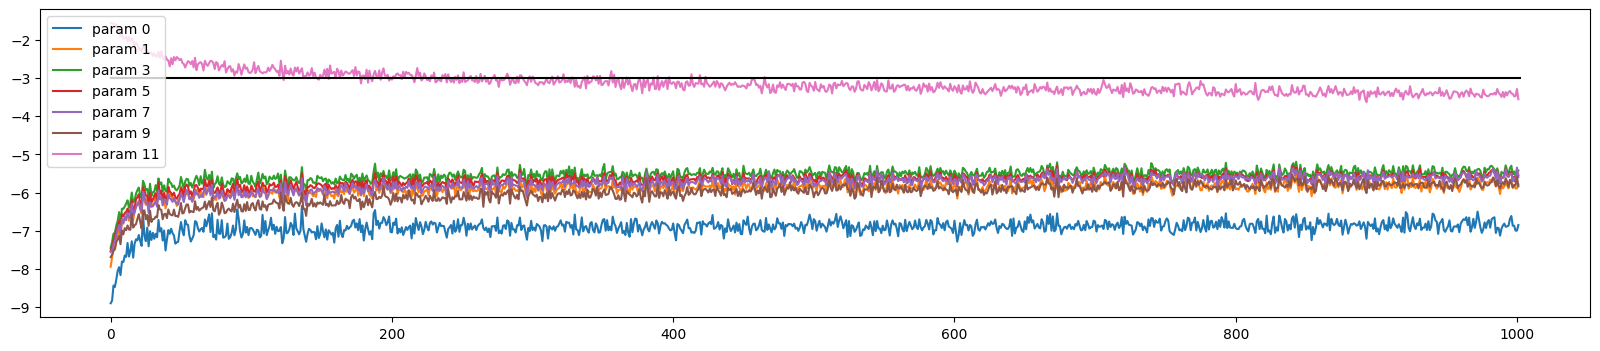

In [44]:
plt.figure(figsize=(20,4))
legends = []
for i,p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be 1e-3, indicate on plot
plt.legend(legends)

In [45]:
# Final layer is an outlier because it was artificially shrunk down to keep the softmax unconfident
# we make the last layer less confident in the init (if you and look back up to the init)
# Good idea to look for evolution of these ratios for every layer
# key is to check that they're not too much above 1e-3
# If they're below 1e-3, then they're not being trained fast enough
# with low lr this learning ratio will be much lower

In [46]:
# Very good way to keep track of the learning
# activations
# gradients
# parameter histograms
# update ratio evolution

In [47]:
# But we are still balancing a pencil, by tweaking everything manually, lets bring back batchnorm and see what happens